#Experiments with aggregating categorical data into sub-groups

So one of the things that you often see in data science competitions is the grouping of categorical data into a smaller number of sub-groups to improve that feature's performance as a predictor of the target variable. In Kaggle's Titanic competition for example you'll very often find people mapping the myriad of passenger titles (Mr, Mrs, Doctor, Major, Lord, Lady etc) to a smaller number of categories (Commoner, Professional, Arisocrat).  This generally is expressed as logically grouping categories that belong together, however I wanted to explore that a little to try figure out if it's a worthwhile technique even when there are no logical groupings (for example, datasets that have the explanatory information removed)

First up, I'll import the usual things plus [f_oneway](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) from scipy to run ANOVA tests.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway
import numpy as np

The dataset I'm using has house prices as the dependent variable against a whole bunch of features, but I'm just going to use one (the type of foundation the house has) since I'm not worried about maximising the actual prediction accuracy, just in the effects of engineering the feature in different ways.

In [2]:
df = pd.read_csv('train.csv',
                    index_col=None)

So let's run a quick boxplot and calculate the p-value

F_onewayResult(statistic=100.25385058740888, pvalue=5.791895002232233e-91)


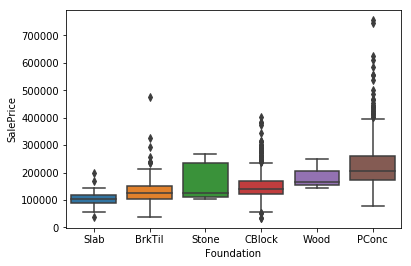

In [3]:
sns.boxplot(x='Foundation',
           y='SalePrice',
           data=df,
            order=df.groupby('Foundation')['SalePrice'].median().sort_values().keys())

vals = df.Foundation.unique()
a = []
for val in vals:
    a.append(df.loc[df.Foundation == val].SalePrice)

print(f_oneway(*a))

Reasonable fit, low p-value. Now I'll map those into some groups and see what happens.

In [4]:
mappings = {
   'Slab':'A',
    'BrkTil':'B',
    'Stone':'B',
    'CBlock':'B',
    'Wood':'C',
    'PConc':'C'
}

df['Found2'] = df['Foundation'].map(mappings)

And now the same boxplot and anova as before

F_onewayResult(statistic=244.99194125658695, pvalue=1.9046134709417034e-92)


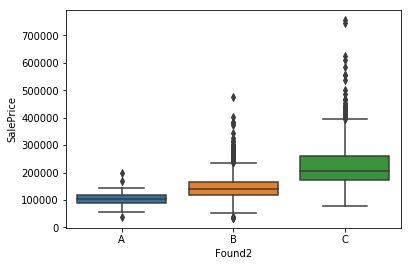

In [5]:
sns.boxplot(x='Found2',
           y='SalePrice',
           data=df,
            order=df.groupby('Found2')['SalePrice'].median().sort_values().keys())

vals = ['A', 'B', 'C']
a = []
for val in vals:
    a.append(df.loc[df.Found2 == val].SalePrice)
    
print(f_oneway(*a))

The fit here is a bit better in that the quantiles are more clearly separated and the p-value is also lower. I'll drop the rest of the features, since I specifically want to play with just the one.

In [6]:
df = df[['Foundation', 'Found2', 'SalePrice']]

Next I'll explode the features into a set of binaries, and transform the originals into numerical ones to stop scikit-learn complaining.

In [7]:
df = pd.concat([df, pd.get_dummies(df.Foundation,
                              prefix='foundation')], axis=1)

df = pd.concat([df, pd.get_dummies(df.Found2,
                                  prefix='found2')], axis=1)

df.Foundation = df.Foundation.astype('category').cat.codes
df.Found2 = df.Found2.astype('category').cat.codes

A quick look...

In [8]:
df.head()

,Foundation,Found2,SalePrice,foundation_BrkTil,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,found2_A,found2_B,found2_C
0,2,2,208500,0,0,1,0,0,0,0,0,1
1,1,1,181500,0,1,0,0,0,0,0,1,0
2,2,2,223500,0,0,1,0,0,0,0,0,1
3,0,1,140000,1,0,0,0,0,0,0,1,0
4,2,2,250000,0,0,1,0,0,0,0,0,1


Great; exactly what I'm looking for. So, we have a lot of models to train. We want:

    1. A model trained on Foundation
    2. A model trained on Found2
    3. A model trained on Foundation*
    4. A model trained on Found2*
    5. A model trained on Foundation_*
    6. A model trained on Found2_*
    7. A model trained on Found*
    8. A model trained on Foundation and Found2
    9. A model trained on Foundation_* and Found2_*
    10. A model trained on Foundation and Found2*

And then we'll take a look at which one performs better. 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = df['SalePrice']
df = df.drop(['SalePrice'], axis=1)

The problem is if we only run it once the answers are kinda at the whims of the RNG gods, so we'll do it a bunch of times (call it a thousand or so) and take the average of each model as its score.

In [13]:
results = pd.DataFrame({'lr1':[],'lr2':[],'lr3':[],'lr4':[],'lr5':[],'lr6':[],'lr7':[],'lr8':[],'lr9':[], 'lr10':[]})
results.columns = [
    'lr1',
    'lr2',
    'lr3',
    'lr4',
    'lr5',
    'lr6',
    'lr7',
    'lr8',
    'lr9',
    'lr10'
]

for i in range(0,1000):
    x_train, x_test, y_train, y_test = train_test_split(df,
                                                    y,
                                                    test_size=0.33)
    
    lr1 = LinearRegression().fit(
        x_train[['Foundation']],
        y_train
    )
    
    lr2 = LinearRegression().fit(
        x_train[['Found2']],
        y_train
    )
    
    lr3 = LinearRegression().fit(
        x_train[[
            'Foundation',
            'foundation_BrkTil',
            'foundation_CBlock',
            'foundation_PConc',
            'foundation_Slab',
            'foundation_Stone',
            'foundation_Wood'
        ]],
        y_train
    )
    
    lr4 = LinearRegression().fit(
        x_train[[
            'Found2',
            'found2_A',
            'found2_B',
            'found2_C'
        ]],
        y_train
    )
    
    lr5 = LinearRegression().fit(
        x_train[[
            'foundation_BrkTil',
            'foundation_CBlock',
            'foundation_PConc',
            'foundation_Slab',
            'foundation_Stone',
            'foundation_Wood'
        ]],
        y_train
    )
    
    lr6 = LinearRegression().fit(
        x_train[[
            'found2_A',
            'found2_B',
            'found2_C'
        ]],
        y_train
    )
    
    lr7 = LinearRegression().fit(
        x_train[[
            'Foundation',
            'foundation_BrkTil',
            'foundation_CBlock',
            'foundation_PConc',
            'foundation_Slab',
            'foundation_Stone',
            'foundation_Wood'
        ]],
        y_train
    )
    
    lr8 = LinearRegression().fit(
        x_train[[
            'Foundation',
            'Found2'
        ]],
        y_train
    )
    
    lr9 = LinearRegression().fit(
        x_train[[
            'foundation_BrkTil',
            'foundation_CBlock',
            'foundation_PConc',
            'foundation_Slab',
            'foundation_Stone',
            'foundation_Wood',
            'found2_A',
            'found2_B',
            'found2_C'
        ]],
        y_train
    )
    
    lr10 = LinearRegression().fit(
        x_train[[
            'Foundation',
            'Found2',
            'found2_A',
            'found2_B',
            'found2_C'
        ]],
        y_train
    )
    
    scores = [
    lr1.score(
        x_test[[
            'Foundation'
        ]],
        y_test
    ),
    lr2.score(
        x_test[[
            'Found2'
        ]],
        y_test
    ),
    lr3.score(
        x_test[[
            'Foundation',
            'foundation_BrkTil',
            'foundation_CBlock',
            'foundation_PConc',
            'foundation_Slab',
            'foundation_Stone',
            'foundation_Wood'
        ]],
        y_test
    ),
    lr4.score(
        x_test[[
            'Found2',
            'found2_A',
            'found2_B',
            'found2_C'
        ]],
        y_test
    ),
    lr5.score(
        x_test[[
            'foundation_BrkTil',
            'foundation_CBlock',
            'foundation_PConc',
            'foundation_Slab',
            'foundation_Stone',
            'foundation_Wood'
        ]],
        y_test
    ),
    lr6.score(
        x_test[[
            'found2_A',
            'found2_B',
            'found2_C'
        ]],
        y_test
    ),
    lr7.score(
        x_test[[
            'Foundation',
            'foundation_BrkTil',
            'foundation_CBlock',
            'foundation_PConc',
            'foundation_Slab',
            'foundation_Stone',
            'foundation_Wood'
        ]],
        y_test
    ),
    lr8.score(
        x_test[[
            'Foundation',
            'Found2'
        ]],
        y_test
    ),
    lr9.score(
        x_test[[
            'foundation_BrkTil',
            'foundation_CBlock',
            'foundation_PConc',
            'foundation_Slab',
            'foundation_Stone',
            'foundation_Wood',
            'found2_A',
            'found2_B',
            'found2_C'
        ]],
        y_test
    ),
    lr10.score(
        x_test[[
            'Foundation',
            'Found2',
            'found2_A',
            'found2_B',
            'found2_C'
        ]],
        y_test
    )
    ]
    
    results.loc[i] = scores

So now we just take the averages:

In [12]:
r2 = pd.DataFrame({'score':[]})
for col in results.columns:
    r2.loc[col] = results[col].mean()
    
r2.score.sort_values(ascending=False)

lr8     2.490660e-01
lr6     2.461020e-01
lr10    2.459908e-01
lr4     2.456027e-01
lr2     2.439789e-01
lr1     1.410223e-01
lr5    -3.195401e+22
lr9    -3.116514e+23
lr7    -1.820658e+24
lr3    -1.820658e+24
Name: score, dtype: float64

Concluding thoughts:

Looks like the model trained on just Foundtion and Found2 is the solid winner. It surprises me that Model 10 including the exlpoded features is a less strong performer, as that's something a lot of people are adamant is worth doing. It could be that that method only becomes more performant if the number of binary features exploded is large enough. Something to explore in the future. In any case, it's pretty conclusive that this is something worth doing even when you're not categorising the features into _logical_ groups.